In [1]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt
import clip
from transformers import CLIPProcessor, CLIPModel

/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/clip/clip.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging
/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3070 Ti


In [3]:
class FishDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.classes = sorted([d for d in os.listdir(img_dir) 
                                    if os.path.isdir(os.path.join(img_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        self.data = []
        for class_name in self.classes:
            class_dir = os.path.join(img_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append((img_path, class_idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, class_idx = self.data[index]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
    
        return image, class_idx

In [4]:
def get_transforms():
    
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [5]:
def create_prompt_function(template="a photograph of a raw fillet of {}"):
    def format_prompt(class_name):
        return template.format(class_name)
    return format_prompt

def create_dataloaders(train_dataset, val_dataset, batch_size=32, num_workers=4):

    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    
    dataloader_kwargs = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers if cuda_available else 0,
        'pin_memory': cuda_available, 
        'persistent_workers': num_workers > 0,
        'prefetch_factor': 2 if num_workers > 0 else 2,
    }
    
    train_loader = DataLoader(train_dataset, **dataloader_kwargs)
    
 
    val_kwargs = dataloader_kwargs.copy()
    val_kwargs['shuffle'] = False
    val_loader = DataLoader(val_dataset, **val_kwargs)
    
    print(f"Device: {device}")
    print(f"Number of classes: {len(train_dataset.classes)}")
    print(f"Classes: {train_dataset.classes}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader, device

In [6]:
train_dir = './all/train'
val_dir = './all/val'
train_transform, val_transform = get_transforms()
prompt_fn = create_prompt_function("a photograph of a raw fillet of {}")
train_dataset = FishDataset(train_dir, transform=train_transform, target_transform=prompt_fn)
val_dataset = FishDataset(val_dir, transform=val_transform, target_transform=prompt_fn)

In [7]:
train_loader, val_loader, device = create_dataloaders(
    train_dataset, val_dataset, batch_size=32, num_workers=4
)

Device: cuda
Number of classes: 5
Classes: ['catfish', 'cod', 'salmon', 'sea bass', 'tuna']
Training samples: 1324
Validation samples: 708


In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model=model.to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
def test_loop(dataloader: DataLoader, model, loss_fn, device):
    model.eval()
    # size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    classes = dataloader.dataset.classes
    prompts = [f"a photograph of a raw fillet of {class_name}" for class_name in classes]
    
    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # tensor-ified the images in dataset. need to untensorfy for PIL processor
            pil_images = []
            for img_tensor in X:
                img_pil = transforms.ToPILImage()(img_tensor)
                pil_images.append(img_pil)
            
            inputs = processor(text=prompts, images=pil_images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            
            logits_per_image = outputs.logits_per_image  # for each image in batch
            probs = logits_per_image.softmax(dim=1) 
            pred = probs.argmax(dim=1)
            
            
            correct += (pred == y).sum().item()
            test_loss += loss_fn(logits_per_image, y).item()



In [10]:
import time
import copy
from collections import defaultdict
import matplotlib.pyplot as plt

def train_clip_model(model, processor, train_loader, val_loader, device, 
                    num_epochs=10, learning_rate=1e-5, weight_decay=1e-4,
                    save_best=True, model_save_path="best_clip_model.pth"):
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    criterion = nn.CrossEntropyLoss()
    
    classes = train_loader.dataset.classes
    prompts = [f"a photograph of a raw fillet of {class_name}" for class_name in classes]
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }
    
    # For saving best model
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Classes: {classes}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 40)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            num_samples = 0
            
            for batch_idx, (images, labels) in enumerate(dataloader):
                images = images.to(device)
                labels = labels.to(device)
                batch_size = images.size(0)
                
                # de-tensorfy images for CLIP processor
                pil_images = []
                for img_tensor in images:
                    img_pil = transforms.ToPILImage()(img_tensor)
                    pil_images.append(img_pil)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = processor(text=prompts, images=pil_images, 
                                     return_tensors="pt", padding=True)
                    inputs = {k: v.to(device) for k, v in inputs.items()}
                    
                    outputs = model(**inputs)
                    logits_per_image = outputs.logits_per_image
                    
                    loss = criterion(logits_per_image, labels)
                    
                    probs = logits_per_image.softmax(dim=1)
                    _, preds = torch.max(probs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data)
                num_samples += batch_size
                
                # Print progress every 20 batches
                if batch_idx % 20 == 0:
                    batch_acc = torch.sum(preds == labels.data).double() / batch_size
                    print(f'  {phase.capitalize()} Batch {batch_idx}/{len(dataloader)}: '
                          f'Loss: {loss.item():.4f}, Acc: {batch_acc:.4f}')
            
            epoch_loss = running_loss / num_samples
            epoch_acc = running_corrects.double() / num_samples
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['learning_rate'].append(optimizer.param_groups[0]['lr'])
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save best model
            if phase == 'val' and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save_best:
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_val_acc': best_val_acc,
                        'history': history,
                        'classes': classes
                    }, model_save_path)
                    print(f'  → New best model saved! Val Acc: {best_val_acc:.4f}')
        
        if scheduler:
            scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
        print()
    
    total_time = time.time() - start_time
    print(f'Training completed in {total_time//60:.0f}m {total_time%60:.0f}s')
    print(f'Best validation accuracy: {best_val_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot accuracy
    axes[0, 1].plot(history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rate
    axes[1, 0].plot(history['learning_rate'], marker='o')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].grid(True)
    
    # Plot validation accuracy zoomed
    axes[1, 1].plot(history['val_acc'], marker='s', color='orange')
    axes[1, 1].set_title('Validation Accuracy (Detailed)')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_detailed(model, processor, dataloader, device, classes):
    """Detailed evaluation with per-class metrics"""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    prompts = [f"a photograph of a raw fillet of {class_name}" for class_name in classes]
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Convert to PIL images
            pil_images = []
            for img_tensor in images:
                img_pil = transforms.ToPILImage()(img_tensor)
                pil_images.append(img_pil)
            
            # Process with CLIP
            inputs = processor(text=prompts, images=pil_images, 
                             return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            _, preds = torch.max(probs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate per-class accuracy
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    for pred, label in zip(all_preds, all_labels):
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1
    
    print("Per-class Results:")
    print("-" * 40)
    for i, class_name in enumerate(classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            print(f"{class_name:>12}: {accuracy:.3f} ({class_correct[i]}/{class_total[i]})")
    
    overall_acc = sum(class_correct.values()) / sum(class_total.values())
    print("-" * 40)
    print(f"{'Overall':>12}: {overall_acc:.3f}")
    
    return all_preds, all_labels, all_probs

Starting training for 10 epochs...
Classes: ['catfish', 'cod', 'salmon', 'sea bass', 'tuna']
Training samples: 1324
Validation samples: 708
------------------------------------------------------------
Epoch 1/10
----------------------------------------
  Train Batch 0/42: Loss: 1.2115, Acc: 0.5625
  Train Batch 20/42: Loss: 0.8297, Acc: 0.6875


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 40/42: Loss: 0.5068, Acc: 0.7812
Train Loss: 0.7335 Acc: 0.7107


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Val Batch 0/23: Loss: 0.5835, Acc: 0.8438


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Val Batch 20/23: Loss: 0.1399, Acc: 0.9375
Val Loss: 0.5112 Acc: 0.8234
  → New best model saved! Val Acc: 0.8234
Epoch completed in 0m 13s

Epoch 2/10
----------------------------------------
  Train Batch 0/42: Loss: 0.3097, Acc: 0.8750
  Train Batch 20/42: Loss: 0.4397, Acc: 0.8438


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 40/42: Loss: 0.4287, Acc: 0.7812
Train Loss: 0.4372 Acc: 0.8353
  Val Batch 0/23: Loss: 0.3452, Acc: 0.8750
  Val Batch 20/23: Loss: 0.1741, Acc: 0.9062
Val Loss: 0.4848 Acc: 0.8249
  → New best model saved! Val Acc: 0.8249
Epoch completed in 0m 13s

Epoch 3/10
----------------------------------------
  Train Batch 0/42: Loss: 0.3055, Acc: 0.8750
  Train Batch 20/42: Loss: 0.2361, Acc: 0.9062


/home/zain/Programming/fishMeat2/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


  Train Batch 40/42: Loss: 0.0938, Acc: 0.9688
Train Loss: 0.2753 Acc: 0.9056
  Val Batch 0/23: Loss: 0.3668, Acc: 0.8750
  Val Batch 20/23: Loss: 0.0900, Acc: 0.9375
Val Loss: 0.4978 Acc: 0.8588
  → New best model saved! Val Acc: 0.8588
Epoch completed in 0m 12s

Epoch 4/10
----------------------------------------
  Train Batch 0/42: Loss: 0.1749, Acc: 0.9688
  Train Batch 20/42: Loss: 0.1845, Acc: 0.9062
  Train Batch 40/42: Loss: 0.2190, Acc: 0.9375
Train Loss: 0.2309 Acc: 0.9184
  Val Batch 0/23: Loss: 0.9623, Acc: 0.7812
  Val Batch 20/23: Loss: 0.4346, Acc: 0.8438
Val Loss: 0.4747 Acc: 0.8602
  → New best model saved! Val Acc: 0.8602
Epoch completed in 0m 12s

Epoch 5/10
----------------------------------------
  Train Batch 0/42: Loss: 0.1381, Acc: 0.9375
  Train Batch 20/42: Loss: 0.0835, Acc: 0.9688
  Train Batch 40/42: Loss: 0.3626, Acc: 0.8750
Train Loss: 0.1313 Acc: 0.9517
  Val Batch 0/23: Loss: 0.8435, Acc: 0.7812
  Val Batch 20/23: Loss: 0.1668, Acc: 0.9062
Val Loss: 0.4

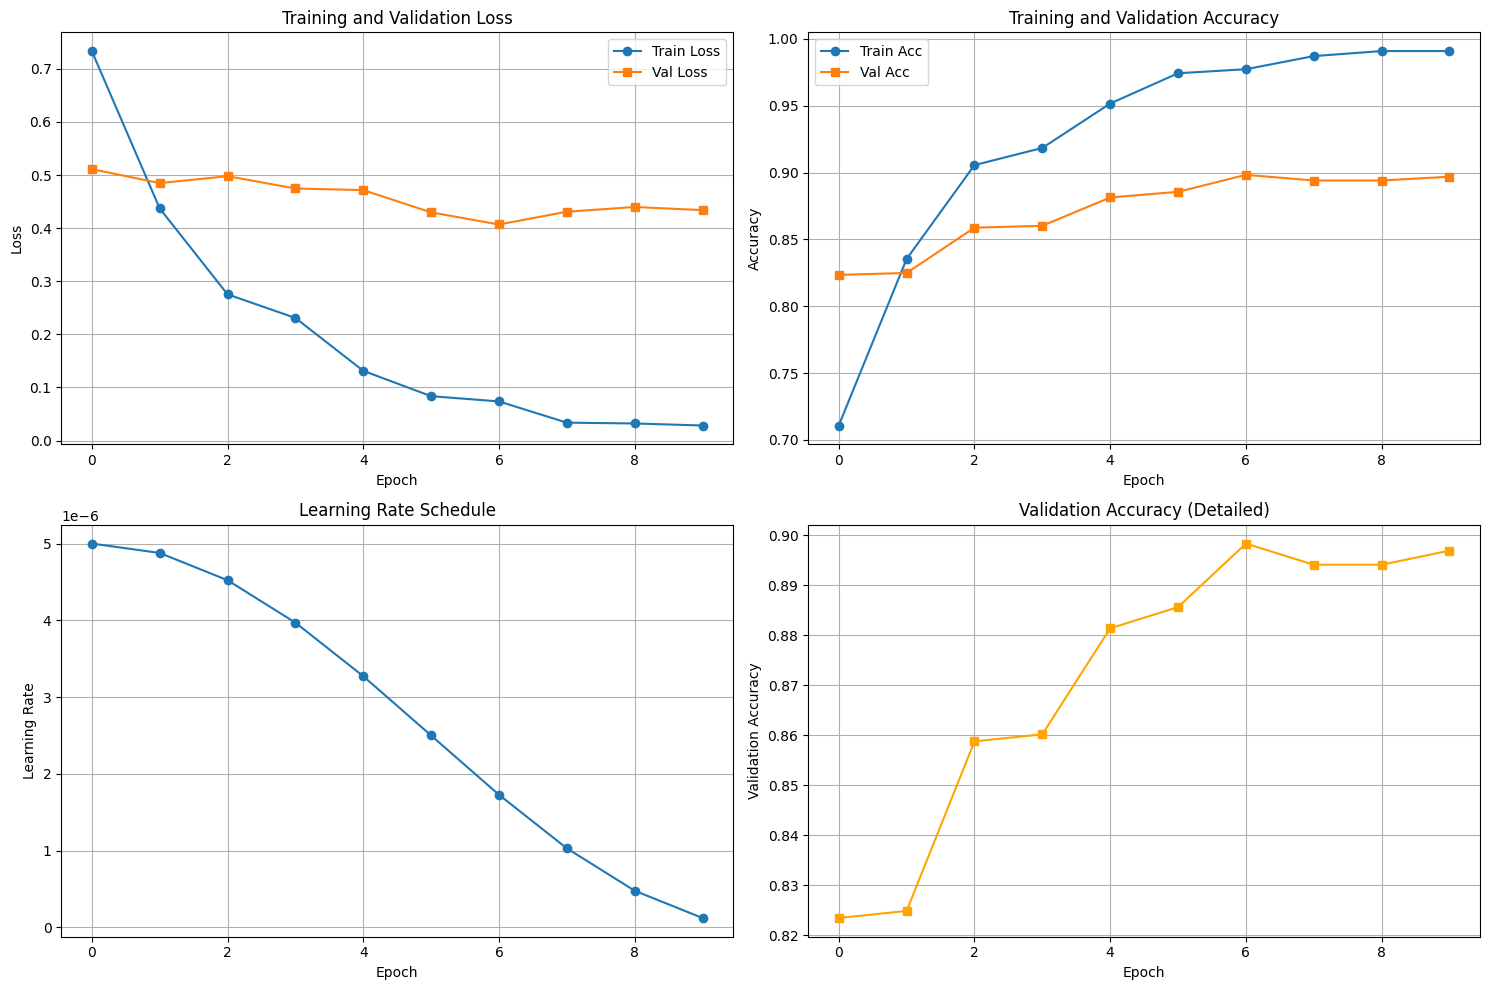

Per-class Results:
----------------------------------------
     catfish: 0.866 (84/97)
         cod: 0.835 (106/127)
      salmon: 0.936 (176/188)
    sea bass: 0.897 (131/146)
        tuna: 0.927 (139/150)
----------------------------------------
     Overall: 0.898


In [12]:
trained_model, training_history = train_clip_model(
    model=model,
    processor=processor, 
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=10,
    learning_rate=5e-6,
    weight_decay=1e-4,
    save_best=True,
    model_save_path="best_fish_clip_model.pth"
)

plot_training_history(training_history)
classes = train_loader.dataset.classes 
preds, labels, probs = evaluate_model_detailed(
    trained_model, processor, val_loader, device, classes
)